# Notebook #01: Designing and evaluating a recommendation algorithm

In this notebook, we will focus on becoming familiar with the recommendation pipeline through a custom Python toolbox, in the simplest possible way. First, we will setup the working environment in GDrive. Then, we will follow the experimental pipeline syep by step, by:
- loading the Movielens 1M dataset; 
- performing a train-test splitting;
- creating a pointwise / pairwise / random / mostpop recommendation object;
- training the model, when applicable;
- computing the user-item matrix of predicted relevance scores;
- calculating a set of evaluation metrics, such as Normalized Discounter Cumulative Gain (NDCG), Coverage, and Novelty. 

The trained models, together with the partial computation we will save (e.g., user-item relevance matrix or metrics), will be the starting point of the investigation and the treatment covered by the other Jupyter notebooks.

## Warm-up: Setup the working environment for this notebook

- Python 3.6
- Package Requirements: pandas, numpy, scipy, matplotlib, scikit-learn, tensorflow. 
- GDrive storage requirements: ~1GB

This step serves to mount GDrive storage within this Jupyter notebook. The command will request us to give access permissions to this notebook, so that we will be able to clone the project repository when we desire. Please follow the prompted instructions.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

We will clone the project repository in our My Drive folder. If you wish to change the target folder, please modify the command below.

In [ ]:
%cd /content/gdrive/My Drive/

## Clone the Github repository into GDrive

If you want to work with the codebase locally in your laptop, you should start to run the following commands.

In [ ]:
! git clone https://github.com/biasinrecsys/icdm2020.git

We will move to the project folder in order to install the required packages. 

In [ ]:
%cd icdm2020

In [ ]:
! ls

In [ ]:
! pip install -r requirements.txt

We will configure the notebooks directory as our working directory in order to simulate a local notebook execution. 

In [ ]:
%cd ./notebooks

## Import Python packages and create the folders for pre-computed results

In [1]:
import sys 
import os

sys.path.append(os.path.join('..'))

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from helpers.train_test_splitter import *
from models.pointwise import PointWise
from models.pairwise import PairWise
from models.mostpop import MostPop
from models.random import Random
from helpers.utils import *

We will define the subfolders in **./data** where we will store our pre-computed results. For each dataset:

- *data/outputs/splits* will include two csv files including the train and test interactions, according with the selected train-test split rule. 
- *data/outputs/instances* will include a csv file with instances to be fed to the model, either pairs for point-wise or triplets for pair-wise recommenders.
- *data/outputs/models* will include a h5 file associated with a pre-trained recommender model.  
- *data/outputs/predictions* will include a numpy file representing a user-item matrix; a cell stores the relevance score of an item for a given user.
- *data/outputs/metrics* will include a pickle dictionary with the computed evaluation metrics for a given recommender model. 

**N.B.** This strategy will allow us to play with the intermediate outputs of the pipeline, without starting from scratch any time (e.g., for performing a bias treatment as a post-processing, we just need to load the predictions of a model to start). 

In [5]:
data_path = '../data/'

In [ ]:
!mkdir '../data/outputs'
!mkdir '../data/outputs/splits'
!mkdir '../data/outputs/instances'
!mkdir '../data/outputs/models'
!mkdir '../data/outputs/predictions'
!mkdir '../data/outputs/metrics'

## Step 1: Load data

First, we will load the **Movielens 1M** dataset, which has been pre-arranged in order to comply with the following structure: user_id, item_id, rating, timestamp, type (label for the item category), and type_id (unique id of the item category). For the sake of tutorial easiness, we assume here that each item is randomly assigned to one of its categories in the original dataset. 

**N.B.** This toolbox is flexible enough to integrate any other dataset in csv format that has the same structure of the pre-arranged csv shown below. No further changes are then needed to the pipeline in order to experiment with other datasets. The csv file of the new dataset sshould be placed into the *data/datasets/* folder and the name of the file should be assigned to the *dataset* parameter below. 

##### Input of this step: CSV file including user preferences

In [6]:
dataset = 'ml1m'  
user_field = 'user_id'
item_field = 'item_id'
rating_field = 'rating'
time_field = 'timestamp'
type_field = 'type_id'

In [7]:
data = pd.read_csv(os.path.join(data_path, 'datasets/' + dataset + '.csv'), encoding='utf8')

In [8]:
data.sample(n=10, random_state=1)

,user_id,item_id,rating,timestamp,type,type_id
630120,3752,319,4.0,2000-08-13 01:03:20,Thriller,15
229398,2411,39,4.0,2000-11-19 00:38:54,Romance,13
758377,2172,2915,3.0,2002-03-02 22:18:54,Comedy,4
159240,2366,349,3.0,2000-11-16 03:11:21,Action,0
254252,1017,377,4.0,2000-11-23 21:15:04,Thriller,15
27168,3391,527,5.0,2000-08-29 19:18:26,Drama,7
196538,2376,1580,4.0,2002-06-19 12:58:43,Comedy,4
37123,4635,783,3.0,2000-07-19 21:31:53,Musical,11
982048,868,1346,4.0,2000-11-26 23:13:31,Horror,10
994502,1880,2275,4.0,2000-11-20 05:37:43,Adventure,1


##### Exercise in brief: find the id of the most popular item (i.e, the item that has received the highest number of ratings).  

In [9]:
# Please, add your solution here
data.groupby(by=['item_id']).size().sort_values(ascending=False).index[0]

2858

During this tutorial, we will simulate a scenario with **implicit feedback**. We assume that a user is interested in an item, if that item was rated by the user, no matter of the rating value. Other strategies can be easily integrated. 

**N.B.** Other papers in the literature assumed that an item is relevant for a user, only if the user has given a rating higher than a value X. To implement this strategy here, you just need to change the body of the lambda function below. 

In [10]:
data[rating_field] = data[rating_field].apply(lambda x: 1.0)

#####  Output of this step: Dataframe / CSV file including pre-processed user preferences 

In [11]:
data.sample(n=10, random_state=1)

,user_id,item_id,rating,timestamp,type,type_id
630120,3752,319,1.0,2000-08-13 01:03:20,Thriller,15
229398,2411,39,1.0,2000-11-19 00:38:54,Romance,13
758377,2172,2915,1.0,2002-03-02 22:18:54,Comedy,4
159240,2366,349,1.0,2000-11-16 03:11:21,Action,0
254252,1017,377,1.0,2000-11-23 21:15:04,Thriller,15
27168,3391,527,1.0,2000-08-29 19:18:26,Drama,7
196538,2376,1580,1.0,2002-06-19 12:58:43,Comedy,4
37123,4635,783,1.0,2000-07-19 21:31:53,Musical,11
982048,868,1346,1.0,2000-11-26 23:13:31,Horror,10
994502,1880,2275,1.0,2000-11-20 05:37:43,Adventure,1


## Step 2: Split data in training and test sets

Once the original dataset has been loaded and the user preferences have been pre-processed, we need to split the whole dataset in two sets: a training set used for optimizing the recommender model and a test set used for evaluating the recommender model. In the literature, a wide range of train-test split strategy exists. This notebook will use a strategy that, for each user, puts the oldest interactions in the training set and the most recent interactions in the test set. The Python toolbox includes also other strategies, such as a random split or a split based on a fixed timestamp (i.e., the most realistic one).  

#####  Input of this step: Dataframe / CSV file including pre-processed user preferences. 

- **smode**: 'uftime' for fixed timestamp split, 'utime' for time-based split per user, 'urandom' for random split per user 
- **train_ratio**: percentage of data to be included in the train set
- **min_train**: minimum number of train samples for a user to be included  
- **min_test**: minimum number of test samples for a user to be included
- **min_time**: start timestamp for computing the splitting timestamp (only for uftime)
- **max_time**: end timestamp for computing the splitting timestamp (only for uftime)
- **step_time**: timestamp step for computing the splitting timestamp (only for uftime)

In [12]:
smode = 'utime'
train_ratio = 0.80        
min_train_samples = 8
min_test_samples = 2
min_time = None
max_time = None
step_time = 1000

During this tutorial, we will work with a common **time-based split per user**. For the sake of clarity, we will provide the implementation of this strategy below. The toolbox conserves all the train-test split strategies into the file *helpers/train_test_splitter.py*.  

In [13]:
def user_timestamp(interactions,split=0.80,min_samples=10,user_field='user_id',item_field='item_id',time_field='timestamp'):
    train_set = []
    test_set = []
    
    groups = interactions.groupby([user_field])
    for i, (index, group) in enumerate(groups):
        
        if i % 1000 == 0:
            print('\r> Parsing user', i+1, 'of', len(groups), end='')
        
        if len(group.index) < min_samples:
            continue
        
        sorted_group = group.sort_values(time_field)
        n_rating_test = int(len(sorted_group.index) * (1.0 - split))
        train_set.append(sorted_group.head(len(sorted_group.index) - n_rating_test))
        test_set.append(sorted_group.tail(n_rating_test))
    
    print('\r> Parsing user', i+1, 'of', len(groups))

    train, test = pd.concat(train_set), pd.concat(test_set)
    train['set'], test['set'] = 'train', 'test' # Ensure that each row has a column that identifies the associated set

    traintest = pd.concat([train, test])
    traintest[user_field + '_original'] = traintest[user_field] # Ensure that we save the original user ids
    traintest[item_field + '_original'] = traintest[item_field] # Ensure that we save the original item ids
    traintest[user_field] = traintest[user_field].astype('category').cat.codes # Ensure that user ids are in [0, |U|] 
    traintest[item_field] = traintest[item_field].astype('category').cat.codes # Ensure that item ids are in [0, |I|] 

    return traintest

This notebook can be easily run with any of the different train-test split strategies, through the following code. 

In [14]:
if smode == 'uftime':
    traintest = fixed_timestamp(data, min_train_samples, min_test_samples, min_time, max_time, step_time, user_field, item_field, time_field, rating_field)
elif smode == 'utime':
    traintest = user_timestamp(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field, time_field)
elif smode == 'urandom':
    traintest = user_random(data, train_ratio, min_train_samples+min_test_samples, user_field, item_field)

> Parsing user 6040 of 6040


**N.B.** For the sake of convenience, *user_ids* and *item_ids* have been scaled so that user_ids are in *[0, |U|]* and item_ids are in *[0, |I|]*. To refer back to the original user and item ids, the *user_id_original* and *item_id_original* columns should be used. 

For the sake of replicability and efficiency of this tutorial, we will save the pre-computed train and test sets in *data/outputs/splits*.

In [15]:
traintest.to_csv(os.path.join(data_path, 'outputs/splits/' + dataset + '_' + smode + '.csv'))

#####  Output of this step: Dataframe / CSV file with interactions assigned to training and test sets

In [16]:
traintest.sample(n=10, random_state=1)

,user_id,item_id,rating,timestamp,type,type_id,set,user_id_original,item_id_original
461252,4681,1980,1.0,2000-08-06 02:31:13,Adventure,1,train,4682,2161
432180,1700,2303,1.0,2001-12-30 08:15:18,Romance,13,train,1701,2497
396031,5688,759,1.0,2000-06-26 05:01:36,Drama,7,train,5689,805
692829,1217,1611,1.0,2000-12-01 18:23:13,Comedy,4,train,1218,1772
333979,1882,2597,1.0,2000-11-22 07:57:02,Action,0,train,1883,2802
524446,226,2958,1.0,2000-12-14 22:41:09,Adventure,1,train,227,3175
52926,1472,1848,1.0,2000-11-20 21:38:38,Action,0,train,1473,2028
895248,307,313,1.0,2001-07-22 22:58:50,Drama,7,train,308,322
285473,5491,2748,1.0,2001-08-07 19:22:33,Drama,7,test,5492,2959
94374,5851,3031,1.0,2000-05-12 05:35:27,Comedy,4,test,5852,3255


## Step 3: Train the recommender model

#####  Input of this step: Dataframe / CSV file with interactions assigned to training and test sets

In [17]:
train = traintest[traintest['set']=='train'].copy()
test = traintest[traintest['set']=='test'].copy()

##### Exercise in brief: plot the distribution of interactions per item in the training set and in the test set, separately.    

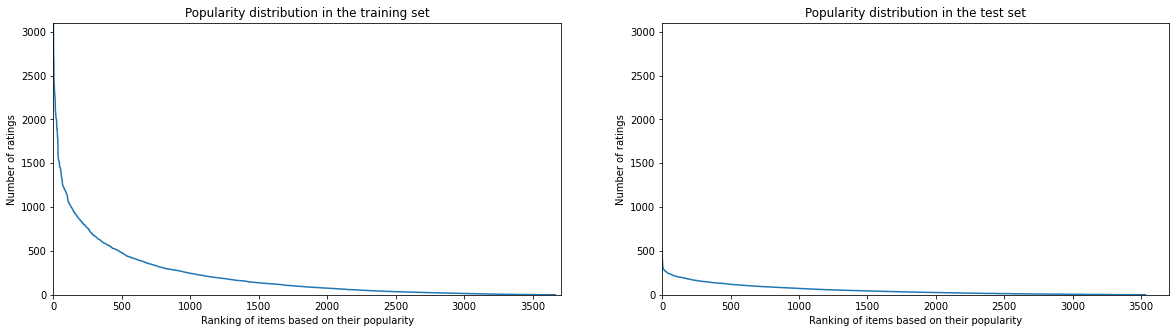

In [19]:
# Please, add your solution here
train_distr = train.groupby(by='item_id').size().sort_values(ascending=False)
test_distr = test.groupby(by='item_id').size().sort_values(ascending=False)
y_max = int(max(train_distr.max(), test_distr.max()) / 100) * 100

plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.title('Popularity distribution in the training set')
plt.plot(range(len(train_distr)), train_distr)
plt.ylim([0, y_max])
plt.xlim([0, len(data['item_id'].unique())])
plt.ylabel('Number of ratings')
plt.xlabel('Ranking of items based on their popularity')

plt.subplot(1,2,2)
plt.title('Popularity distribution in the test set')
plt.plot(range(len(test_distr)), test_distr)
plt.ylim([0, y_max])
plt.xlim([0, len(data['item_id'].unique())])
plt.ylabel('Number of ratings')
plt.xlabel('Ranking of items based on their popularity')

plt.savefig('train_test_pop_distr.png')
plt.show()

First, we show some statistics about the training and test sets, e.g., number of users and items. 

In [20]:
users = list(np.unique(traintest[user_field].values))
items = list(np.unique(traintest[item_field].values))

In [21]:
len(users), len(items)

(6040, 3706)

Given that some recommender models may require the category of an item, we create a vector of size *|I|* including the integer-encoded category of the item with id *X* at position *X* of the vector. 

In [22]:
category_per_item = traintest.drop_duplicates(subset=['item_id'], keep='first')[type_field].values

In [23]:
len(np.unique(category_per_item))

18

For the sake of easiness and time, this tutorial focuses on four main recommendation strategies: 
- *Random*: randomly recommending a list of items to a user. 
- *MostPop*: recommending the same most popular items (i.e, those which received the highest number of ratings) to all users.
- *PointWise*: given a user-item pair, it is optimized for predicting a higher score (1) when the current item has been rated by the user, and a lower score (0) otherwise. The training instances include a good reprsentation of both types of pairs.   
- *PairWise*: given a triplet with a user, an observed item, and an unobserved item, it is optimized for predicting a higher relevance for the pair of user and unobserved item rather than for the pair of user and unobserved item. 

Each model inherits from the Model class defined in *models/model.py* and extends it by overwriting the *train* and *predict* functions of the original model class. This allows us to minimize the reuse of the code. More details on the implementation of the pairwise recommender can be found into *models/pairwise.py*.  

In [24]:
model_types = {'random': Random, 'mostpop': MostPop, 'pointwise': PointWise, 'pairwise': PairWise}

First, we need to initialize the model. We will see how the process works for a PairWise algorithm. Then, we will consider the other ones. 

In [25]:
model_type = 'pairwise'
%time model = PairWise(users, items, train, test, category_per_item, item_field, user_field, rating_field)

Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Wall time: 12.1 s


We will train the model by feeding the train data we previously prepared, using the following default parameters. 

- *no_epochs* (default 100): maximum number of epochs until which the training process will be run. 
- *batches* (default 1024): size of the batches fed into the model during training. 
- *lr* (default 0.001): learning rate defining the pace at which the model will be trained. 
- *no_factors* (default 10): size of the latent vectors associated to users and items. 
- *no_negatives* (default 10): number of triplets for each user-item pair included in the training set. 
- *val_split* (default 0.0001): proportion of the training set used for validation. 

**N.B.** For the sake of tutorial efficiency, we force to stop the training process after 5 epochs (i.e., reasonable trade-off). No grid search on the recommender model is performed at this stage. 

In [26]:
%time model.train(no_epochs=5) 

Generating training instances of type pair
Created training instances randomly
Computing instances for interaction 800000 / 803798 of type pair
Performing training - Epochs 5 Batch Size 1024 Learning Rate 0.001 Factors 10 Negatives 10 Mode pair
Train on 7957600 samples
7957600/7957600 [==============================] - 60s 8us/sample - loss: 0.1912 - acc_loss: 0.1912 - corr_loss: 0.3082
Validation accuracy: 0.8611594924110475 (Sample 80379 of 80380)
Train on 7957600 samples
Epoch 2/2
7957600/7957600 [==============================] - 54s 7us/sample - loss: 0.1321 - acc_loss: 0.1321 - corr_loss: 0.3434
Train on 7957600 samples
Epoch 3/3
7957600/7957600 [==============================] - 47s 6us/sample - loss: 0.1114 - acc_loss: 0.1114 - corr_loss: 0.3069
Train on 7957600 samples
Epoch 4/4
7957600/7957600 [==============================] - 43s 5us/sample - loss: 0.0982 - acc_loss: 0.0982 - corr_loss: 0.2660
Train on 7957600 samples
Epoch 5/5
7957600/7957600 [=============================

The architecture of the trained model looks as follows. Essentially, the model includes:
- *UserEmb* encoding a latent vector for each user.
- *ItemEmb* encoding a latent vector for each item.
- *FlatUserEmb* represents the vector associated with the current user *UserInput*.
- *FlatPosItemEmb* represents the vectors associated with the current observed item *PosItemInput*.
- *FlatNegItemEmb* represents the vectors associated with the current unobserved item *NegItemInput*.
- *Accuracy* computes the margin between (i) the *FlatUserEmb-FlatPosItemEmb* and (ii) the *FlatUserEmb-FlatNegItemEmb* similarity scores.  

In [27]:
model.print()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
UserInput (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
PosItemInput (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
NegItemInput (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
UserEmb (Embedding)             (None, 1, 10)        60410       UserInput[0][0]                  
______________________________________________________________________________________________

#####  Output of this step: H5 TensorFlow model pre-trained with the interactions in the training set

The model file is saved in *data/outputs/models*. 

In [28]:
model

## Step 4: Compute user-item relevance scores

Once the recommender model has been trained, we leverage the pre-trained user and item Embedding matrices in order to compute the relevance score predicted for each unseen user-item pair. For all the user-item pairs, the prediction step requires to extract the user and item vector associated to the current user-item pair and, then, compute the similarity between the two - cosine or dot similarity are usually used at this stage.  

#####  Input of this stage: H5 Tensorflow model pre-trained with the interactions in the training set

In [29]:
model

Now, we will use the pre-trained model to predict the user-item relevance scores.

In [30]:
model.predict()

Computing predictions


For the sake of easiness, you could directly manipulate the user-item relevance matrix as a numpy array. 

In [31]:
scores = model.get_predictions()

Hence, we can access to the relevance score of the user *120* for the item *320* as follows. 

In [32]:
user_id, item_id = 120, 320
scores[user_id, item_id]

3.735388994216919

##### Exercise in brief: compute the range of the scores on the whole population of users.     

In [33]:
# Please, add your solution here
scores.min(), scores.max()

(-32.77223587036133, 40.23173141479492)

For the sake of convenience, we will save the predicted scores. They are often used as an input for re-ranking treatments against bias. 

In [34]:
save_obj(scores, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + smode + '_' + model_type + '_scores.pkl'))

##### Exercise in brief: retrieve the ids of the 10 items having the highest relevance score for the user with id 47.   

In [35]:
# Please, add your solution here
np.argsort(scores[47])[::-1][:10]

array([1120, 1449, 1106,  466,  253,  575, 2651, 2426, 2374, 1178],
      dtype=int64)

#####  Output of this step: Numpy matrix of size |U|*|I| containing the user-item relevance scores

In [36]:
scores.shape

(6040, 3706)

## Step 5: Generate recommendations and compute evaluation metrics

Finally, with the user-item relevance scores predicted in the previous step, we can generate the recommendations for each user and, then, compute a set of well-known evaluation metrics for recommender systems. 

#####  Input of this step: Numpy matrix of size |U|*|I| containing the user-item relevance scores and a list of cutoffs

In [37]:
scores.shape

(6040, 3706)

In [38]:
cutoffs = np.array([5, 10, 20, 50, 100, 200])

For the sake of convenience, for the considered recommender model, we also compute some fairness metrics required for the case studies. The following line of code loads the demographic membership of providers, which will be discussed in detail in Notebook #03.

**N.B.** While the gender is by no means a binary construct, to the best of our knowledge no dataset for speaker recognition with non-binary genders exists. What we are considering is a binary feature, as the current publicly available datasets offer.

In [39]:
gender_item_association = pd.read_csv(os.path.join(data_path, 'datasets', 'ml1m-dir-gender.csv')) 

This dataframes includes, for each item, the percentage of providers with gender_1 and gender_2 for that item, respectively. 

In [40]:
gender_item_association.sample(n=10, random_state=1)

,item_id,gender_1,gender_2
3582,1886,0.0,1.0
2073,2079,0.0,1.0
2425,2745,NaN,NaN
93,2490,0.0,1.0
79,2236,0.0,1.0
1459,144,0.0,1.0
3398,758,NaN,NaN
366,1095,0.0,1.0
2724,3568,0.0,1.0
2162,3124,1.0,0.0


##### Exercise in brief: compute the percentage of items where at least one provider having gender_1 is represented.  

In [41]:
# Please, add your solution here
print(round(len(gender_item_association[gender_item_association['gender_1'] > 0.0]) / len(items), 2))

0.05


In [42]:
gender_maps = {i:g for i, g in zip(gender_item_association['item_id'], gender_item_association['gender_1'])}
item_maps = {i1:i2 for i1, i2 in zip(traintest['item_id'].unique(), traintest['item_id_original'].unique())}

In [43]:
item_group = [(1 if item_maps[i] in gender_maps and gender_maps[item_maps[i]] == 0 else 0) for i in range(len(items))]

Then, we run the function which computes all the metrics relevant for the subsequent case studies. 

In [44]:
model.test(item_group=item_group, cutoffs=cutoffs)

Computing metrics for user 6040 / 6040


The method has pre-computed a set of metrics and saved the corresponding values in a Python dictionary, as detailed below. 

In [45]:
metrics = model.get_metrics()

In [46]:
metrics.keys()

dict_keys(['precision', 'recall', 'ndcg', 'hit', 'mean_popularity', 'diversity', 'novelty', 'item_coverage', 'visibility', 'exposure'])

The values for each metrics have been computed and store for each cutoff.

In [47]:
for name, values in metrics.items():
    print(values.shape, name)

(6, 6040) precision
(6, 6040) recall
(6, 6040) ndcg
(6, 6040) hit
(6, 6040) mean_popularity
(6, 6040) diversity
(6, 6040) novelty
(6, 3706) item_coverage
(6, 6040) visibility
(6, 6040) exposure


For instance, we can access to the NDCG score for the user *120* at cutoff *10*, with the following commands.

In [48]:
user_id, cutoff_index = 1324, int(np.where(cutoffs == 10)[0])
metrics['ndcg'][cutoff_index, user_id]

0.3494867399516553

##### Exercise in brief: compute the catalog coverage (i.e., percentage of items recommended at least once) at top-20.  

In [49]:
# Please, add your solution here
print(round(len([1 for m in metrics['item_coverage'][int(np.where(cutoffs == 20)[0])] if m > 0]) / len(items), 2))

0.31


For the sake of convenience, we will save the compted metrics.

In [50]:
save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + smode + '_' + model_type + '_metrics.pkl'))

We can also see the aggregated values. 

In [51]:
model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

Precision: 0.1155 
Recall: 0.048 
NDCG: 0.1258 
Hit Rate: 0.5139 
Avg Popularity: 1987.3643 
Category Diversity: 0.3319 
Novelty: 1.7276 
Item Coverage: 0.21 
User Coverage: 0.5139
Minority Exposure: 0.0307
Minority Visibility: 0.0336


#####  Output of this step: Dictionary of evaluation metrics 
---

In [52]:
' - '.join(list(metrics.keys()))

'precision - recall - ndcg - hit - mean_popularity - diversity - novelty - item_coverage - visibility - exposure'

---

## Step 7: Run the pipeline for Random, MostPop, and PointWise

We will define a utility function to run all the above operations jointly for each of the other recommender models.

In [53]:
def run_model(model_type, no_epochs=None):
    print('Running model', model_type)
    model = model_types[model_type](users, items, train, test, category_per_item, item_field, user_field, rating_field)
    model.train(no_epochs=no_epochs) if no_epochs else model.train() 
    model.predict()
    scores = model.get_predictions()
    save_obj(scores, os.path.join(data_path, 'outputs/predictions/' + dataset + '_' + smode + '_' + model_type + '_scores.pkl'))
    model.test(item_group=item_group, cutoffs=cutoffs)
    metrics = model.get_metrics()
    save_obj(metrics, os.path.join(data_path, 'outputs/metrics/' + dataset + '_' + smode + '_' + model_type + '_metrics.pkl'))
    print('\n\nFinal evaluation metrics:')
    model.show_metrics(index_k=int(np.where(cutoffs == 10)[0]))

In [54]:
run_model('random')

Running model random
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Computing predictions
Computing metrics for user 6040 / 6040


Final evaluation metrics:
Precision: 0.0096 
Recall: 0.003 
NDCG: 0.0098 
Hit Rate: 0.0879 
Avg Popularity: 196.5536 
Category Diversity: 0.331 
Novelty: 6.9893 
Item Coverage: 1.0 
User Coverage: 0.0879
Minority Exposure: 0.1693
Minority Visibility: 0.1692


In [55]:
run_model('mostpop')

Running model mostpop
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Computing predictions
Computing metrics for user 6040 / 6040


Final evaluation metrics:
Precision: 0.1007 
Recall: 0.0384 
NDCG: 0.1096 
Hit Rate: 0.4422 
Avg Popularity: 2328.0848 
Category Diversity: 0.3293 
Novelty: 1.3922 
Item Coverage: 0.03 
User Coverage: 0.4422
Minority Exposure: 0.0509
Minority Visibility: 0.0616


In [ ]:
run_model('pointwise', no_epochs=5)

Running model pointwise
Initializing user, item, and categories lists
Initializing observed, unobserved, and predicted relevance scores
Initializing item popularity lists
Initializing category per item
Initializing category preference per user
Initializing metrics
Generating training instances of type point
Computing instances for interaction 800000 / 803798 of type point
Performing training - Epochs 5 Batch Size 1024 Learning Rate 0.001 Factors 10 Negatives 10 Mode point
Train on 7957600 samples, validate on 884178 samples
Epoch 1/5
7957600/7957600 [==============================] - 112s 14us/sample - loss: 0.2097 - val_loss: 0.2373
Epoch 2/5
7957600/7957600 [==============================] - 77s 10us/sample - loss: 0.1754 - val_loss: 0.2391
Epoch 3/5
7957600/7957600 [==============================] - 61s 8us/sample - loss: 0.1668 - val_loss: 0.2395
Epoch 00003: early stopping
Computing predictions for user 1200 / 6040

## Follow-up: how to extend the toolbox

- New splitter: take a look at the helpers/train_test_splitter.py file and how the existing generators have been defined. 
- New train instances creator: similarly, take a look at the helpers/instances_creator.py file and how the existing generators have been defined. 
- New model: a new subclass of the Model class defined in models/model.py should be defined, implementing a 'train' and a 'predict' method. 
- New metrics: both the 'test' and 'show_metrics' methods of models/model.py should be extended with the computation needed by the new metric.  